# Instead of test the algorithms and affinity on the whole dataset, this notebook test data from each trial, which is what we need in implementation.

# Without anchor object

# SSP encoding.   Rerun!!!

Encode the data set as obj_sp*(c_1 * bolt_ssp + c_2 * nut_ssp) + coord_sp * coord_ssp

<IPython.core.display.Javascript object>


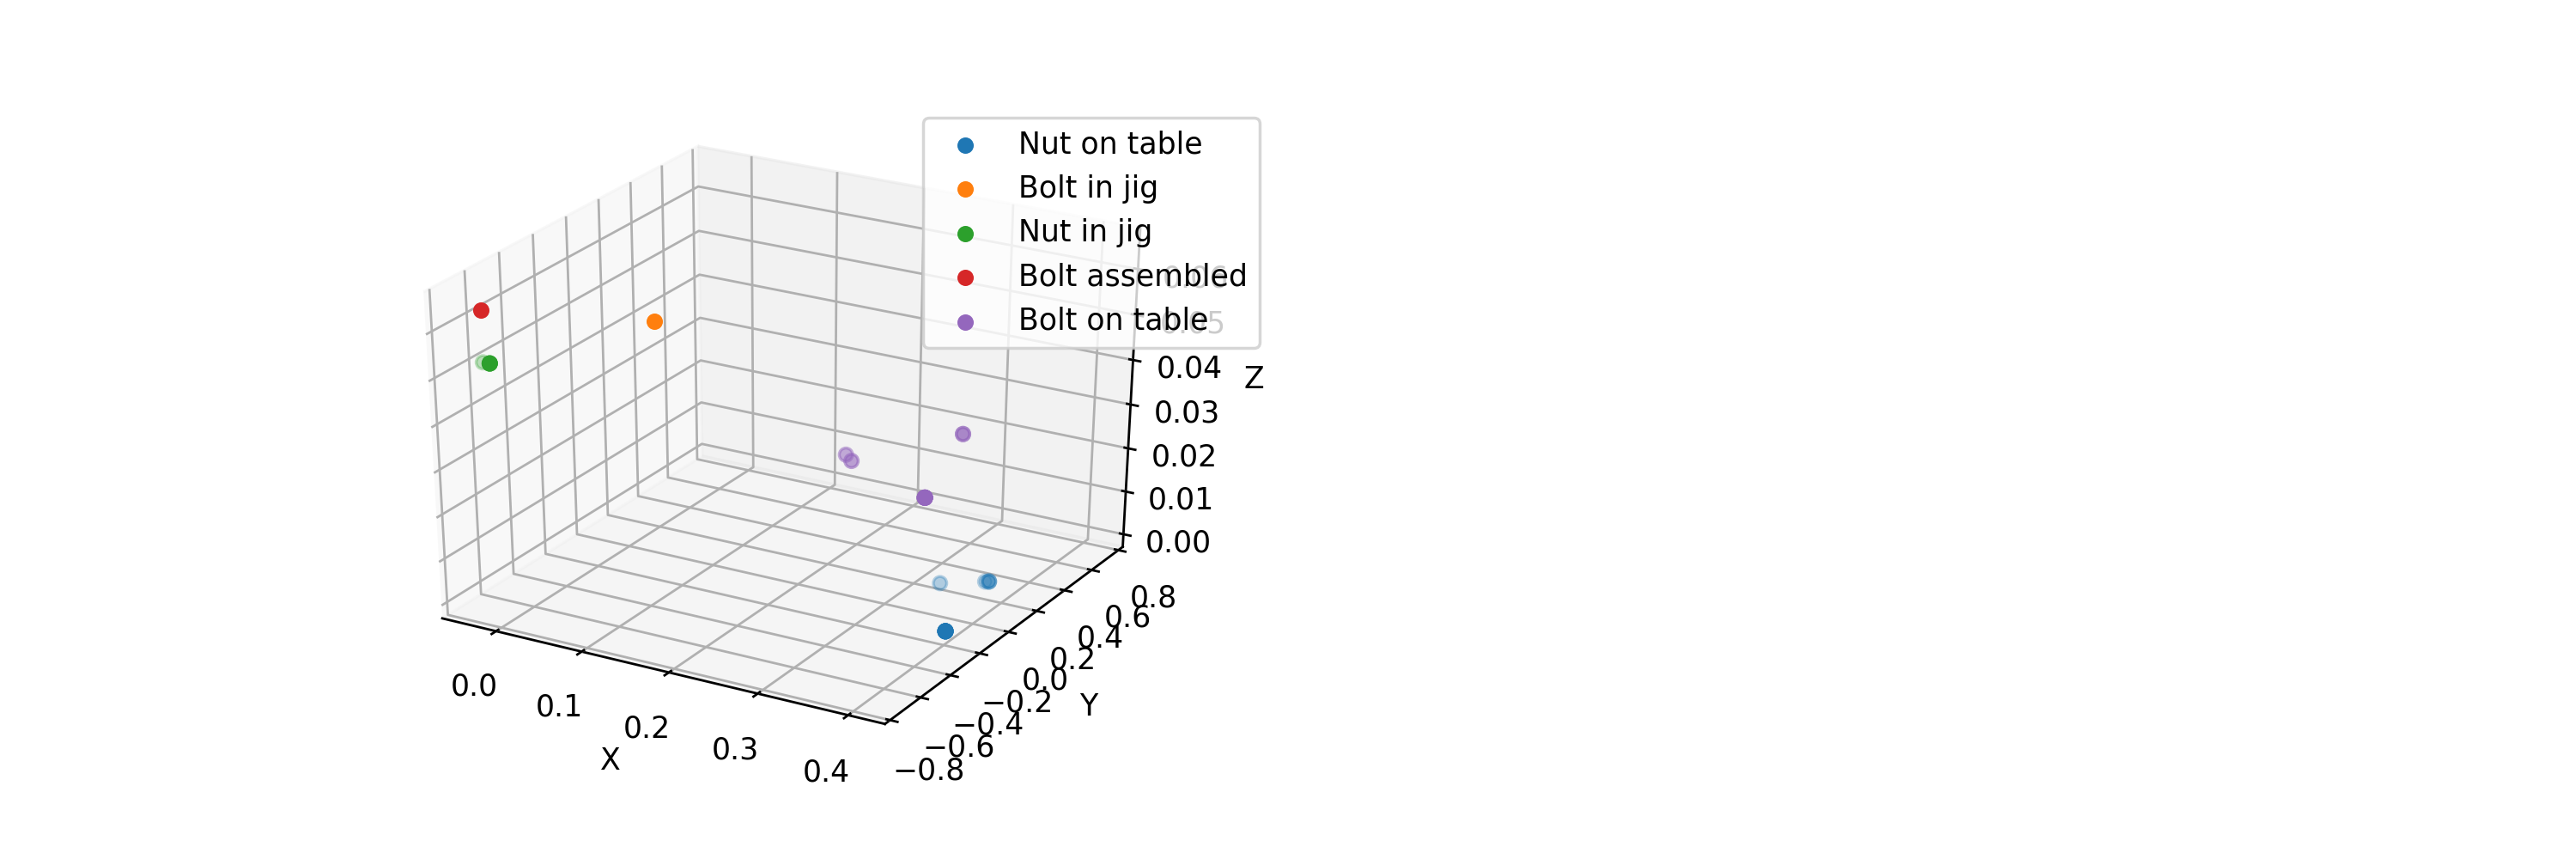

In [1]:
import numpy as np
%matplotlib notebook
import sys
sys.path.append('..')

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from utils.data import fetch_data, fetch_data_with_label, fetch_data_with_label_per_step, generate_data, label_to_int, divide_data
from utils.plotting import plot
from utils.clustering import agglomerative, kmeans, gaussian_mixture, Clustering
from sklearn.metrics import adjusted_rand_score
import itertools


logfile_path = ['../data/raw/1599166289/data.pickle', '../data/raw/1599153598/data.pickle', '../data/raw/test/data.pickle']

#coordinates and object kind for nut and bolt
data_concat, label = fetch_data_with_label_per_step(logfile_path)

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))


coord = selected_data[:,0:3]
obj_kind = selected_data[:, 3]

fig = plt.figure(1, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord, selected_label)


In [2]:
def balance_data(data, labels):
    count = []
    for label in set(labels):
        count.append((labels == label).sum())
    max_count = max(count)
    for label in set(labels):
        n_data = (labels == label).sum()
        if n_data < max_count:
            ind = np.where(labels == label)[0]
            selected_data = data[ind, :]
            average = np.average(selected_data, axis = 0)
            n_needed = max_count - n_data
            data_needed = np.tile(average, (n_needed, 1))
            label_needed = np.tile(label, n_needed)
            data = np.concatenate((data, data_needed), axis = 0)
            labels = np.concatenate((labels, label_needed))
    return data, labels

In [4]:
from utils.encoding import power, make_good_unitary, encode_point, encode_dataset
import nengo.spa as spa

def encode_property(data, sps):
    '''
    data: an n by m array. n is the number of data points, m is the number of possible choices of the property being encoded.
          (ex. when encoding object kind, the possible choices of object kind are 'bolt' and 'nut').
    sps: A list of size m. Each entry is the semantic pointer for each of the possible choices.
    '''
    n = data.shape[0]
    dim = len(sps[0].v)
    result = []
    for i in range(n):
        result.append((data[i] * sps).sum())
    return np.array(result)

def encode_dataset(data, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind_sp, obj_sp, coord_sp):
    
    n = data.shape[0]
    dim = len(x_axis_sp.v)
    result = np.zeros((n, dim))
    for i in range(n):
        x = data[i][0].item()
        y = data[i][2].item()
        z = data[i][1].item()
        point_encoded = encode_point(x, y, z, x_axis_sp, y_axis_sp, z_axis_sp)
        result[i, :] = (coord_sp* point_encoded + obj_sp * encoded_kind_sp[i]).v
    return result
        
dim = 256
x_axis_sp = make_good_unitary(dim)
y_axis_sp = make_good_unitary(dim)
z_axis_sp = make_good_unitary(dim)

bolt_sp = make_good_unitary(dim)
nut_sp = make_good_unitary(dim)

obj_sp = make_good_unitary(dim)
coord_sp = make_good_unitary(dim)

# Agglomerative with P-nom and number of clusters. Object kind is used as a soft constrain.

<IPython.core.display.Javascript object>


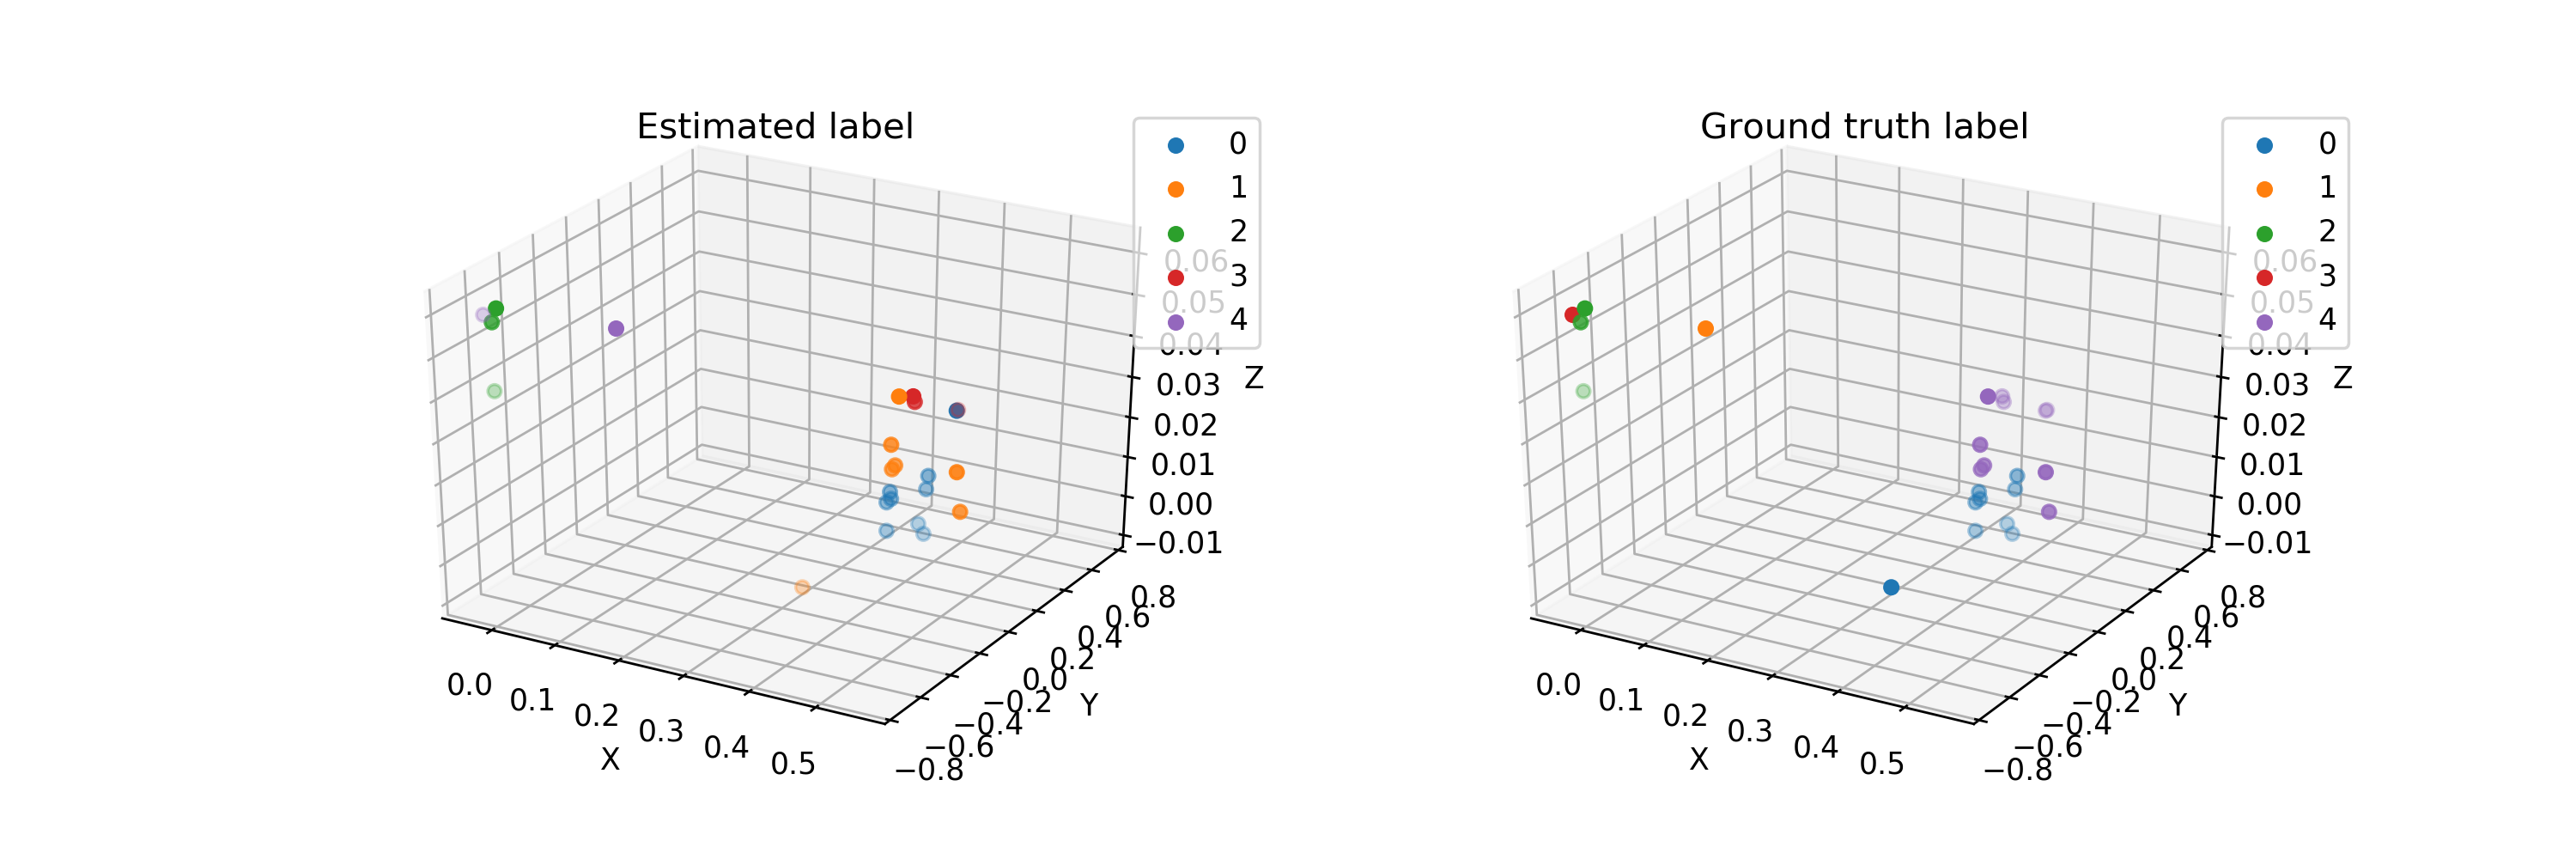

The accuracy for nut and bolt is 0.5414673046251993


In [5]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
u_anchor = 0.1
sigma_anchor = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot = np.zeros((n_data,2))
one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, obj_sp, coord_sp)

estimated_label_concat = agglomerative(data_encoded, 'p_norm', thres = None, n_clusters = 5, p = -2)

n_original = selected_data.shape[0]
fig = plt.figure(2, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
plt.title('Estimated label')
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
plt.title('Ground truth label')
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])}')

In [6]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot = np.zeros((n_data,2))
    one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

    encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
    data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, obj_sp, coord_sp)

    estimated_label_concat = agglomerative(data_encoded, 'p_norm', thres = None, n_clusters = 5, p = -2)


    n_original = selected_data.shape[0]
    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

KeyboardInterrupt: 

# Agglomerative with Euclidean and number of clusters. Object kind is used as a soft constrain.

<IPython.core.display.Javascript object>


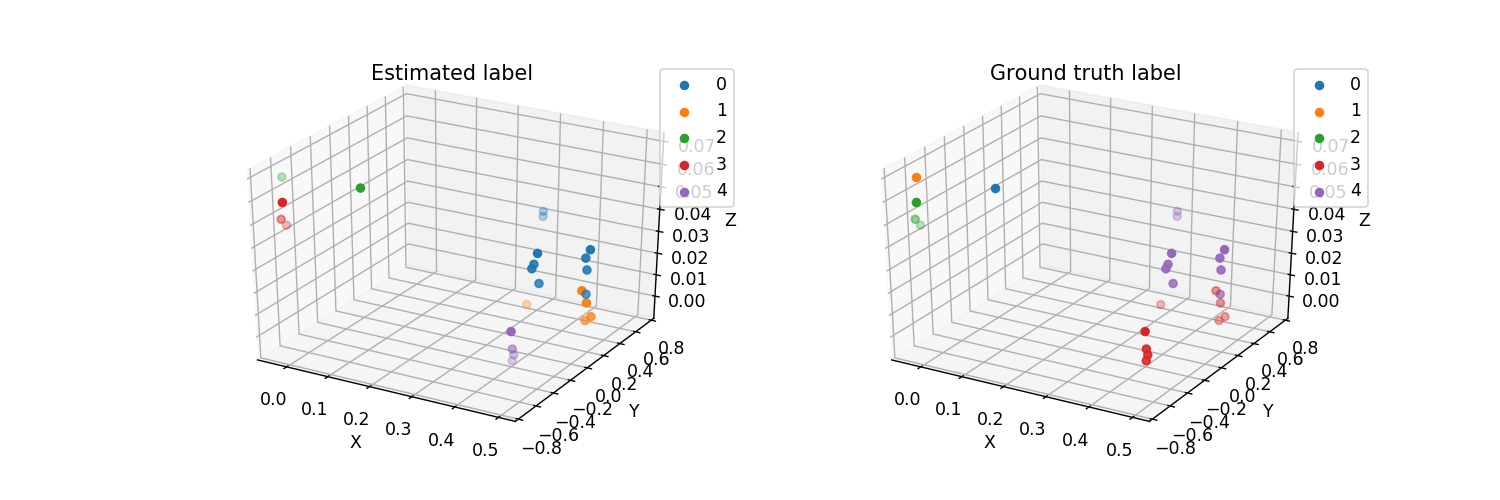

The accuracy for nut and bolt is 0.8081048867699643


In [6]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
u_anchor = 0.1
sigma_anchor = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot = np.zeros((n_data,2))
one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, obj_sp, coord_sp)

estimated_label_concat = agglomerative(data_encoded, 'euclidean', thres = None, n_clusters = 5)

n_original = selected_data.shape[0]
fig = plt.figure(3, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
plt.title('Estimated label')
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
plt.title('Ground truth label')
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])}')

In [7]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot = np.zeros((n_data,2))
    one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

    encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
    data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, obj_sp, coord_sp)

    estimated_label_concat = agglomerative(data_encoded, 'euclidean', thres = None, n_clusters = 5, p = -2)


    n_original = selected_data.shape[0]
    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

0.8143695450118374


# Agglomerative with Cosine and number of clusters. Object kind is used as a soft constrain.

<IPython.core.display.Javascript object>


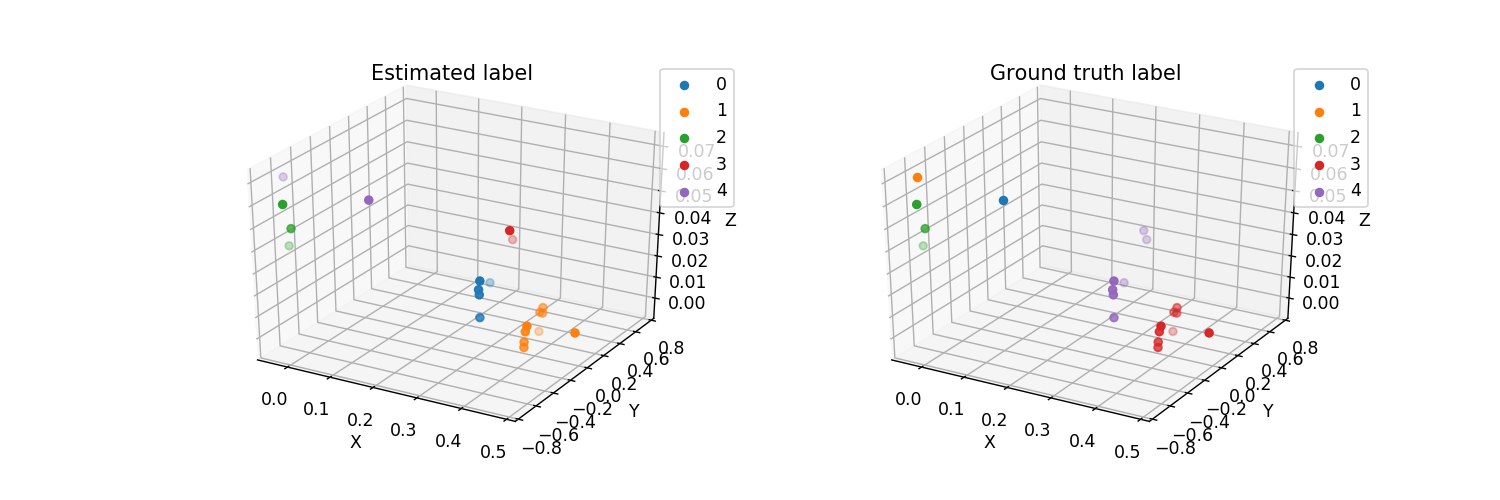

The accuracy for nut and bolt is 0.8656195462478186


In [8]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
u_anchor = 0.1
sigma_anchor = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot = np.zeros((n_data,2))
one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, obj_sp, coord_sp)

estimated_label_concat = agglomerative(data_encoded, 'cosine', thres = None, n_clusters = 5)

n_original = selected_data.shape[0]
fig = plt.figure(4, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
plt.title('Estimated label')
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
plt.title('Ground truth label')
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])}')

In [9]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot = np.zeros((n_data,2))
    one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

    encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
    data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, obj_sp, coord_sp)

    estimated_label_concat = agglomerative(data_encoded, 'cosine', thres = None, n_clusters = 5, p = -2)


    n_original = selected_data.shape[0]
    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

0.8331389649303437


# Kmeans with P-nom and number of clusters. 

..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)


<IPython.core.display.Javascript object>


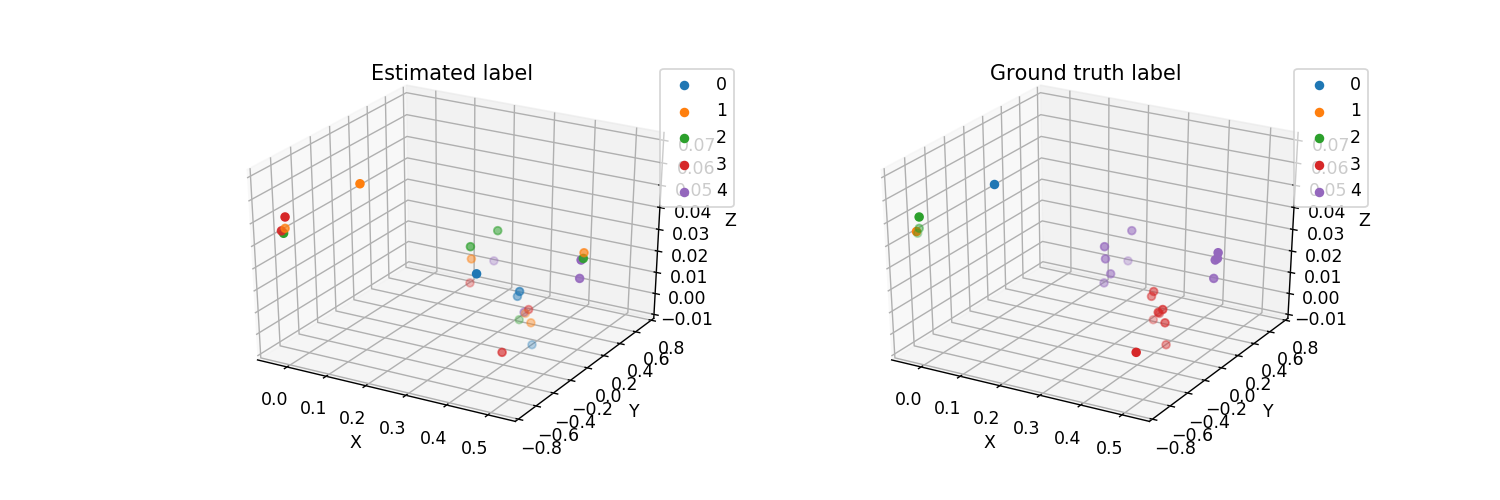

The accuracy for nut and bolt is -0.04501061571125266


In [10]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
u_anchor = 0.1
sigma_anchor = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot = np.zeros((n_data,2))
one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, obj_sp, coord_sp)

estimated_label_concat, centers = kmeans(data_encoded, n_clusters = 5 , affinity = 'p_norm')

n_original = selected_data.shape[0]
fig = plt.figure(5, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
plt.title('Estimated label')
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
plt.title('Ground truth label')
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])}')

In [11]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot = np.zeros((n_data,2))
    one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

    encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
    data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, obj_sp, coord_sp)

    estimated_label_concat, centers = kmeans(data_encoded, n_clusters = 5 , affinity = 'p_norm')


    n_original = selected_data.shape[0]
    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[

..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[i] = np.sum(difference ** p) ** (1 / p)
..\utils\distances.py:17: RuntimeWarning: divide by zero encountered in power
  distances[

0.003259471653346046


# Kmeans with Euclidean and number of clusters. 

<IPython.core.display.Javascript object>


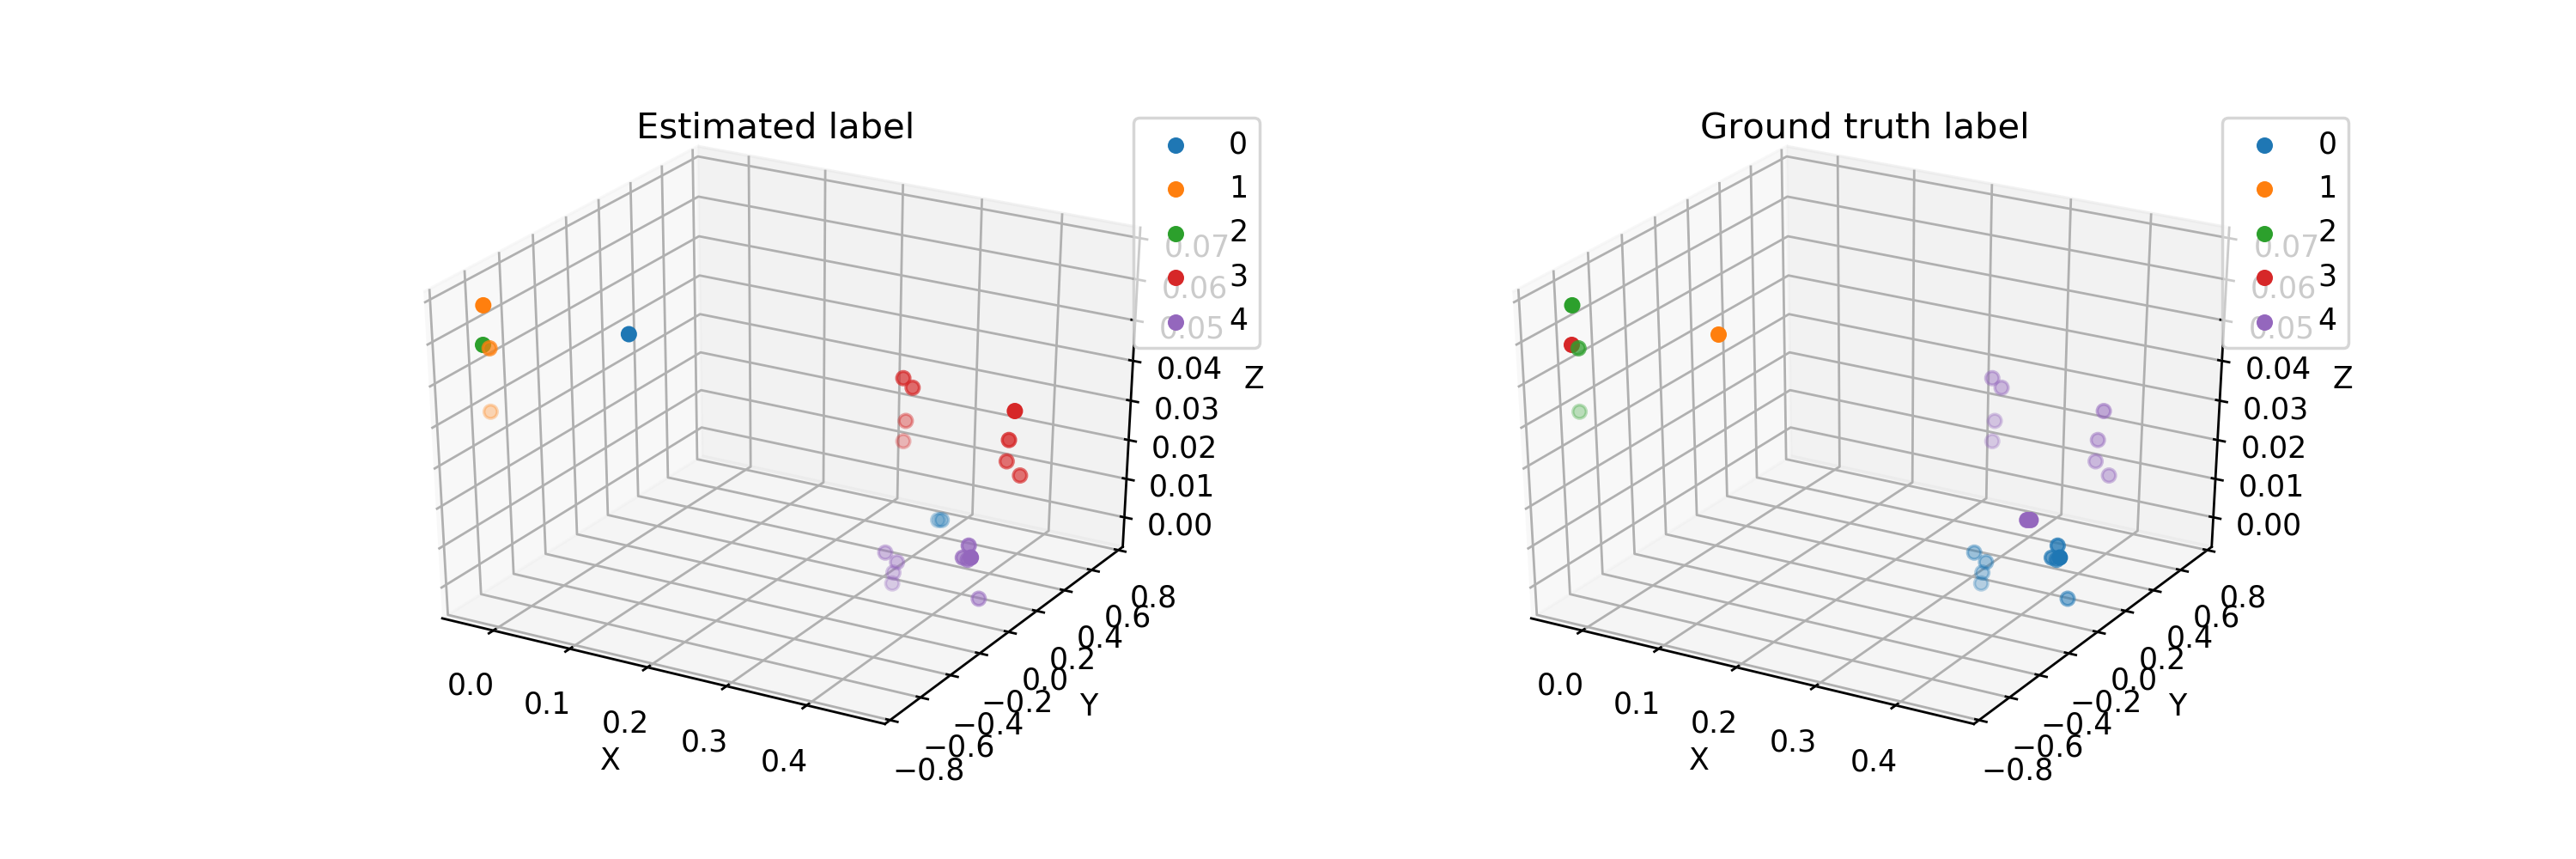

The accuracy for nut and bolt is 0.8384074941451991


In [7]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
u_anchor = 0.1
sigma_anchor = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot = np.zeros((n_data,2))
one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, obj_sp, coord_sp)

estimated_label_concat, centers = kmeans(data_encoded, n_clusters = 5 , affinity = 'euclidean')

n_original = selected_data.shape[0]
fig = plt.figure(6, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
plt.title('Estimated label')
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
plt.title('Ground truth label')
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])}')

In [13]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot = np.zeros((n_data,2))
    one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

    encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
    data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, obj_sp, coord_sp)

    estimated_label_concat, centers = kmeans(data_encoded, n_clusters = 5 , affinity = 'euclidean')


    n_original = selected_data.shape[0]
    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

0.9159105223163231


# Kmeans with Cosine and number of clusters. 

<IPython.core.display.Javascript object>


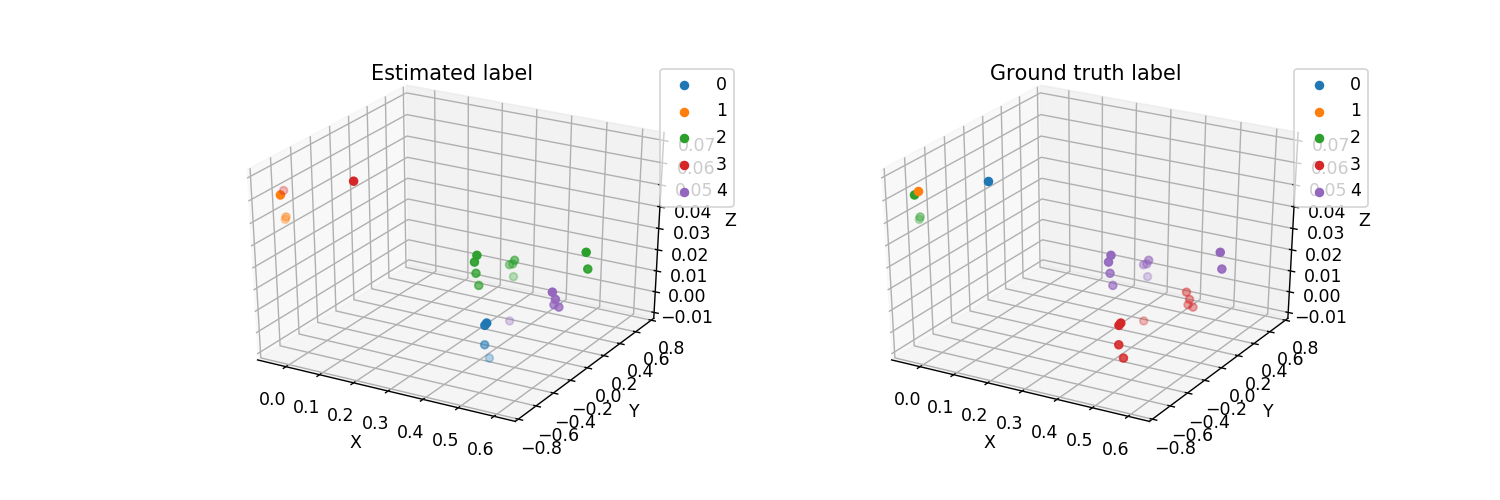

The accuracy for nut and bolt is 0.8081048867699643


In [14]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
u_anchor = 0.1
sigma_anchor = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot = np.zeros((n_data,2))
one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, obj_sp, coord_sp)

estimated_label_concat, centers = kmeans(data_encoded, n_clusters = 5 , affinity = 'cosine')

n_original = selected_data.shape[0]
fig = plt.figure(7, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
plt.title('Estimated label')
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
plt.title('Ground truth label')
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])}')

In [15]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot = np.zeros((n_data,2))
    one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

    encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
    data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, obj_sp, coord_sp)

    estimated_label_concat, centers = kmeans(data_encoded, n_clusters = 5 , affinity = 'cosine')


    n_original = selected_data.shape[0]
    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

0.8295564901056522


# Gaussian mixture model

<IPython.core.display.Javascript object>


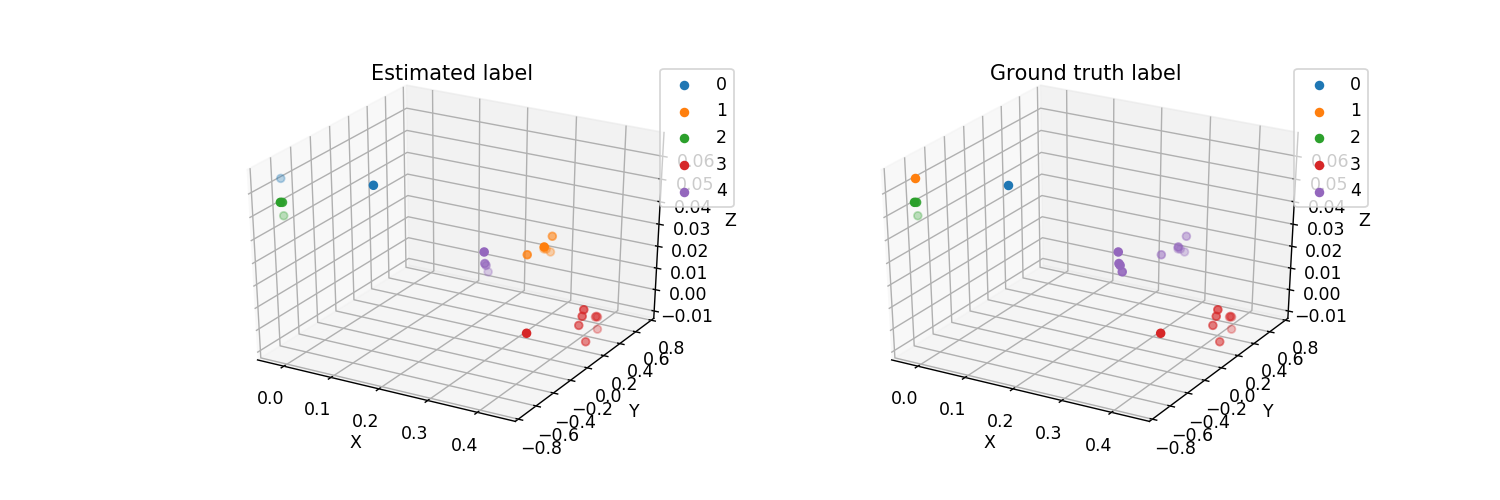

The accuracy for nut and bolt is 0.7682386134623136


In [16]:
u_coord = 0  # The average shift between the approximated coordinates and ground truth
sigma_coord = 0.006
u_kind = 0.1
sigma_kind = 0.05
u_anchor = 0.1
sigma_anchor = 0.05

ind = np.random.choice(len(data_concat))
selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
selected_label_int = label_to_int(selected_label_balanced)

coord = selected_data_balanced[:,0:3]
obj_kind = selected_data_balanced[:, 3]

noise = np.random.normal(u_coord, sigma_coord, coord.shape)
coord_noisy = coord + noise

ind_nut = np.where(obj_kind == 0)[0]
ind_bolt = np.where(obj_kind == 1)[0]

n_data = coord.shape[0]
one_hot = np.zeros((n_data,2))
one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, obj_sp, coord_sp)

estimated_label_concat, centers = gaussian_mixture(data_encoded, n_clusters = 5)

n_original = selected_data.shape[0]
fig = plt.figure(8, (12,4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot(ax, coord_noisy[:n_original,:], estimated_label_concat[:n_original])
plt.title('Estimated label')
ax = fig.add_subplot(1, 2, 2, projection='3d')
plot(ax, coord_noisy[:n_original,:], selected_label_int[:n_original])
plt.title('Ground truth label')
print(f'The accuracy for nut and bolt is {adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])}')

In [17]:
n_test = 100
accuracy = 0
for i in range(n_test):
    ind = np.random.choice(len(data_concat))
    selected_data = np.array(list(itertools.chain.from_iterable(data_concat[ind])))
    selected_label = np.array(list(itertools.chain.from_iterable(label[ind])))

    selected_data_balanced, selected_label_balanced = balance_data(selected_data, selected_label)
    selected_label_int = label_to_int(selected_label_balanced)

    coord = selected_data_balanced[:,0:3]
    obj_kind = selected_data_balanced[:, 3]

    noise = np.random.normal(u_coord, sigma_coord, coord.shape)
    coord_noisy = coord + noise

    ind_nut = np.where(obj_kind == 0)[0]
    ind_bolt = np.where(obj_kind == 1)[0]

    n_data = coord.shape[0]
    one_hot = np.zeros((n_data,2))
    one_hot[np.arange(obj_kind.size),obj_kind.astype(int)] = 1
    noise_kind = np.random.normal(u_kind, sigma_kind, obj_kind.size)
    kind_noisy = abs(one_hot - np.column_stack((noise_kind, noise_kind)))

    encoded_kind = encode_property(kind_noisy, [nut_sp, bolt_sp])
    data_encoded = encode_dataset(coord_noisy, x_axis_sp, y_axis_sp, z_axis_sp, encoded_kind, obj_sp, coord_sp)

    estimated_label_concat , centers= gaussian_mixture(data_encoded, n_clusters = 5)


    n_original = selected_data.shape[0]
    accuracy += adjusted_rand_score(estimated_label_concat[:n_original], selected_label_int[:n_original])
    
print(accuracy / n_test)

0.8146882969253961
